# Sentinel-2 Sunglint Finder with Earth Engine Python API

This notebook shows how to find Sentinel-2 scenes over sunglint geometry using the Earth Engine Python API.  
Adjust the `bbox`, `start_date`, `end_date`, and other parameters as needed.


In [10]:
# 1. Install and import Earth Engine Python API
# Uncomment the following line if running in Colab or a new environment:
# !pip install earthengine-api
%load_ext autoreload
%autoreload 2


import os
import sys
module_path = os.path.abspath(os.path.join('..', 'offshore_methane'))
if module_path not in sys.path:
    sys.path.append(module_path)


import rasterio
import ee
import geopandas as gpd
import geemap
from sunglint import add_sgi_b8a_b3, add_abascal_sun_glint_bands, print_s2_metadata_angles, expanded_into_mosaic, add_cloud_probability, plot_mosaic_scatter ,mosaic_scatter, add_sgi_b12_b3
from mbsp import compute_scaling_coefficient
from utils import *
import pandas as pd
from shapely.geometry import Polygon, Point
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import math
# ee.Authenticate()
ee.Initialize()
print('Earth Engine initialized.')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Earth Engine initialized.


### Load Infrastructure in the Gulf of Mexico

<Axes: >

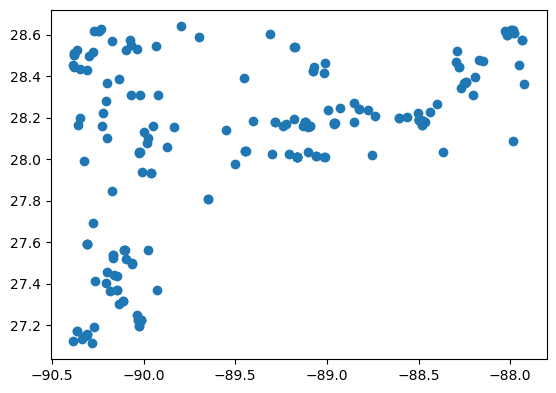

In [11]:

infra = pd.read_csv(r"C:\Users\ebeva\SkyTruth\methane\nonoise_SAR_fixed_infrastructure.csv")

# 1. Define the Gulf of Mexico bounding box
min_lon, min_lat = -98.0, 24.0
max_lon, max_lat = -80.5, 31.0

# Define the polygon as a shapely Polygon (longitude, latitude order)
gulf_poly = Polygon([
    (-90.384631, 23.859054),
    (-90.384631, 28.645609),
    (-85.68112, 28.645609),
    (-85.68112, 23.859054),
    (-90.384631, 23.859054)
])

# Create GeoDataFrame from infra DataFrame
gdf = gpd.GeoDataFrame(
    infra,
    geometry=[Point(xy) for xy in zip(infra['lon'], infra['lat'])],
    crs="EPSG:4326"
)

# Filter gdf by whether points are within the polygon
gdf_gulf = gdf[gdf.geometry.within(gulf_poly)]
gdf_gulf.plot()

### Find a specific infrastructure in the gulf

In [12]:

# infra.sample(1)
# row = gdf_gulf.sample(1).iloc[0]
# stationary_infra = ee.Geometry.Point([row['lon'], row['lat']])
# Map = geemap.Map()
# Map.addLayer(stationary_infra)
# Map.centerObject(stationary_infra, 6)
# Map

### Pull Imagery and display

In [255]:
def get_s2_collection(start_date, end_date, stationary_infra, cloud_percent=20):
    return (
        ee.ImageCollection('COPERNICUS/S2_SR')
        .filterDate(start_date, end_date)
        .filterBounds(stationary_infra)
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', cloud_percent))
    )

# s2 = get_s2_collection('2018-01-01', '2025-12-01', stationary_infra=stationary_infra)

In [256]:
# sorted_s2 = s2.sort('MEAN_SOLAR_ZENITH_ANGLE').toList(10)
# idx = 1
# glint_example = ee.Image(sorted_s2.get(idx))

In [257]:
# print_s2_metadata_angles(glint_example)

In [ ]:

# # sgi_b8a_b3 = add_sgi_b8a_b3(glint_example).select("sgi_b8a_b3")
# # abascal_glint_score = add_abascal_sun_glint_bands(glint_example).select("abascal_glint_score")
# abascal_glint_score = expanded_into_mosaic(glint_example, band_operation_fn=add_abascal_sun_glint_bands, band_name="abascal_glint_score")
# sgi_b8a_b3 = expanded_into_mosaic(glint_example,add_sgi_b8a_b3,"sgi_b8a_b3")
# sgi_b12_b3 = expanded_into_mosaic(glint_example,add_sgi_b12_b3,"sgi_b12_b3")
# glint_example_cloud = expanded_into_mosaic(glint_example, add_cloud_probability, "cloud_probability")
# glint_example_mosiac = expanded_into_mosaic(glint_example)

In [14]:
# # Visualize RGB - .visualize(bands=['B4', 'B3', 'B2'], min=0, max=4000)
# # Visualize single band {'min': -1, 'max': 1, 'palette': ['blue', 'white', 'red']}
# Map = geemap.Map()

# Map.addLayer(glint_example_mosiac.visualize(bands=['B12'], min=0, max=3000),{}, 'S2 b12', False)
# # Map.addLayer(glint_example_cloud, {'min': 0, 'max': 100, 'palette': ['blue', 'white', 'red']}, "cloud_probability", False)
# # Map.addLayer(abascal_glint_score, {'min': 0, 'max': 20, 'palette': ['blue', 'white', 'red']}, "abascal_glint", False)


# Map.addLayer(sgi_b8a_b3, {'min': -.5, 'max': .5, 'palette': ['blue', 'white', 'red']}, "sgi_b8a_b3")
# Map.addLayer(sgi_b12_b3, {'min': -.5, 'max': .5, 'palette': ['blue', 'white', 'red']}, "sgi_b12_b3")

# #Zhang et al. SGI < -0.5 indicates no glint, i,e glint is -0.5 and above
# Map.addLayer(sgi_b12_b3.gt(-0.1), {'min': -.5, 'max': .5, 'palette': ['blue', 'white', 'red']}, "sgi_mask")

# Map.addLayer(sgi_b12_b3.subtract(sgi_b8a_b3), {'min': -.05, 'max': .05, 'palette': ['blue', 'white', 'red']}, "subtract", False)
# Map.addLayer(glint_example_mosiac.visualize(bands=['B4', 'B3', 'B2'], min=0, max=4000),{}, 'Color S2')
# Map.addLayer(stationary_infra,{'color': 'red'}, 'Stationary')

# Map.centerObject(stationary_infra, 9)
# Map

In [15]:
# roi_feature = Map.draw_last_feature
# if roi_feature is not None:
#     scatter = mosaic_scatter(glint_example_mosiac.select("B4"), sgi_b8a_b3, roi_feature.geometry()) #bx_name="B13", by_name="SGI")


In [ ]:
def get_s2_collection_from_feature(feature, date_pad_days=1, cloud_thresh=20):
    """
    Given an ee.Feature with lat/lon geometry and start_date/end_date in milliseconds,
    return a filtered Sentinel-2 image collection.

    Args:
        feature (ee.Feature): An Earth Engine Feature with geometry and metadata properties.
        date_pad_days (int): Days to pad around the timestamp.
        cloud_thresh (float): CLOUDY_PIXEL_PERCENTAGE threshold for filtering.

    Returns:
        ee.ImageCollection: Filtered Sentinel-2 ImageCollection.
    """
    # Extract geometry
    geom = feature.geometry()

    # Extract date (assume start_date and end_dateti are in milliseconds)
    start_ms = ee.Number(feature.get('start_date'))
    end_ms = ee.Number(feature.get('end_dateti'))

    # Convert to ISO strings with padding
    start_date = ee.Date(start_ms).advance(-date_pad_days, 'day')
    end_date = ee.Date(end_ms).advance(date_pad_days, 'day')

    # Build filtered collection
    collection = (
        ee.ImageCollection("COPERNICUS/S2_HARMONIZED")
        .filterDate(start_date, end_date)
        .filterBounds(geom)
        .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", cloud_thresh))
    )

    return collection



In [276]:
point_object.getInfo()

{'type': 'Feature',
 'geometry': {'type': 'Point',
  'coordinates': [-92.29091970068319, 19.601057782876296]},
 'id': '00000000000000000010',
 'properties': {'end_dateti': 1693378800000,
  'latitude': 19.60106,
  'longitude': -92.29092,
  'platform': '',
  'region': 'Mexico',
  'satellite': 'Sentinel-2 - ESA',
  'source': 'UNEP IMEO MARS',
  'start_date': 1693378800000,
  'volume (kg': 33819,
  'volume unc': 11518,
  'wind_speed': 2.89}}

In [272]:
i=0
plumes = ee.FeatureCollection("projects/ee-brendan-skytruth/assets/unepIMEO_plumes_sentinel2")
point_object = plumes.toList(41).get(i)
point = ee.Feature(plumes.toList(41).get(i))
plume_s2 = get_s2_collection_from_feature(point_object.getInfo())

AttributeError: 'dict' object has no attribute 'geometry'

In [262]:

# # lat, lon = 27.59, -90.31  # Gulf of Mexico example
# lat, lon = 27.29220815000002, -90.96802087968751  # GOOD example
# start, end = dt.date(2017, 7, 4), dt.date(2024, 7, 6)  # Broad
# start, end = dt.date(2022, 9, 14), dt.date(2022, 9, 16)  # Broad

# # start, end = dt.date(2017, 7, 4), dt.date(2017, 7, 6)  # Good example
# i+=1
# print(i)
# point = ee.Geometry.Point(lon, lat)
# collection = (
#     ee.ImageCollection("COPERNICUS/S2_HARMONIZED")
#     .filterDate(str(start), str(end))
#     .filterBounds(point.geometry())
#     .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 20))
# )

# collection = collection.map(calculateSunglint_alpha)
# # collection = collection.filter(ee.Filter.lt('glint_alpha',20)).sort('glint_alpha')

# images = collection.toList(collection.size())
# count = images.size().getInfo()

# print(f"Found {count} images")

In [246]:
i=-1

In [254]:

i+=1
granule = ee.Image(images.get(i))
print("ID:", i, " -- sunglint:", granule.get('glint_alpha').getInfo(), "--", granule.get('system:index').getInfo())
bbox = point.buffer(1000).bounds()  # 500 meters buffer = 1 km box
c=1
Map = geemap.Map()
Map.addLayer(granule.visualize(bands=['B4', 'B3', 'B2'], min=0, max=4000),{}, 'Color S2')
Map.addLayer(granule.multiply(c).visualize(bands=['B12'], min=0, max=3000),{}, 'S2 b12', True)
Map.addLayer(granule.visualize(bands=['B11'], min=0, max=3000),{}, 'S2 b11', True)
# Map.addLayer(collection.mosaic().visualize(bands=['B10'], min=0, max=10),{}, 'S2 b10', False)

Map.addLayer(bbox, {'color': 'red'}, 'BBOX of Interest', False)
Map.addLayer(point, {'color': 'red'}, "point" )
Map.centerObject(point,14)
Map

EEException: Collection.toList: The value of 'count' must be positive. Got: 0.

In [177]:
granule

In [103]:
sample = granule.sampleRectangle(region=bbox, defaultValue=0)

# 5. Convert to NumPy arrays
# red = np.array(sample.get('B4').getInfo())
green = np.array(sample.get('B3').getInfo())
# blue = np.array(sample.get('B2').getInfo())

b12 = granule.select('B12')  # 20m
b9 = granule.select('B9')    # 60m
b10 = granule.select('B10')
b3 = granule.select('b3') # 10m

# Resample B9 to match B12 resolution
b9_resampled = b9.resample('bicubic').reproject(crs=b12.projection())
rescaled_img = b12.addBands(b9_resampled.rename('B9_resampled'))
sample_b9 = rescaled_img.sampleRectangle(region=bbox)

b10_resampled = b10.resample('bicubic').reproject(crs=b12.projection())
rescaled_img = b12.addBands(b10_resampled.rename('B10_resampled'))
sample_b10 = rescaled_img.sampleRectangle(region=bbox)

b11 = np.array(sample.get('B11').getInfo())
b12 = np.array(sample.get('B12').getInfo())
b9 = np.array(sample_b9.get('B9_resampled').getInfo())
b10 = np.array(sample_b10.get('B10_resampled').getInfo())

In [104]:
# threshold = b11.flatten()<1500
# len(b11.flatten()[b11.flatten()<1500])

In [105]:
coeffs = np.polyfit(b12.flatten(), b11.flatten(), deg=1)  # degree 1 = linear
m, b = coeffs
b11_fit = m * b12 + b

poly_coeffs = np.polyfit(b11.flatten(), b12.flatten(), deg=4)  # degree 1 = linear

# Turn into function
p = np.poly1d(poly_coeffs)
b11_fit_poly = p(b12)

In [106]:
c = compute_scaling_coefficient(b11, b12)
b11_fit_c = c * b12

In [107]:
print(c)

1.280047124562283


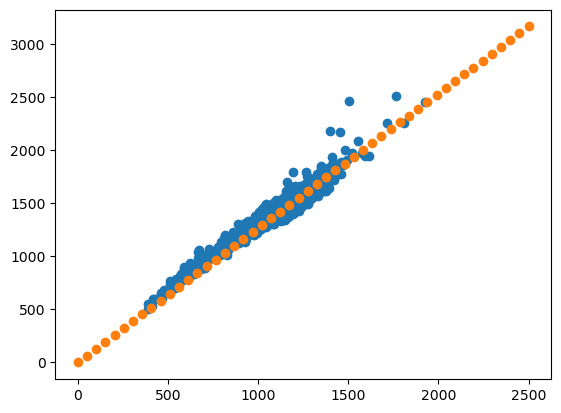

In [ ]:
# plt.scatter(b12,b11)
# plt.scatter(np.linspace(0,2500), m*np.linspace(0,2500)+ b)

plt.scatter(b12,b11)
plt.scatter(np.linspace(0,2500), c*np.linspace(0,2500))

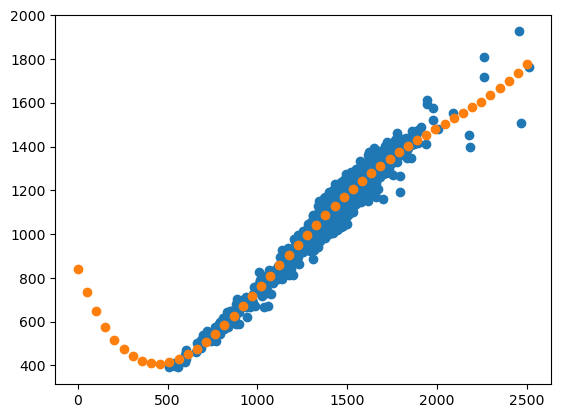

In [ ]:
plt.scatter(b11,b12)
plt.scatter(np.linspace(0,2500), p(np.linspace(0,2500)))

In [ ]:
flip = True


linear


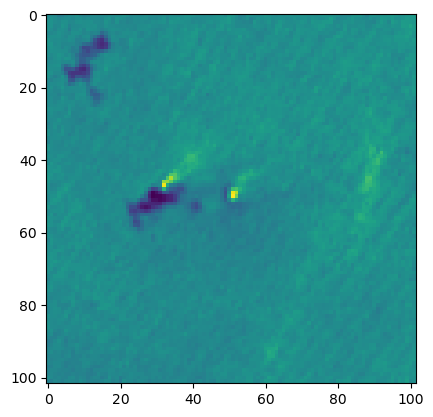

In [ ]:
mbsp = (c * b12 - b11)/b11
linear_mbsp = (b11_fit-b11)/b11
poly_mbsp = (b11_fit_poly-b11)/b11

do_flip = True
if flip and do_flip:
    print("linear")
    plt.imshow(b11)
    flip = False 
else:
    print("poly")
    plt.imshow(b12)
    flip = True


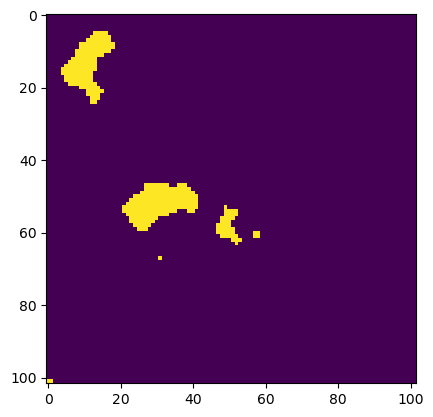

In [ ]:
plt.imshow(b9<170)


In [ ]:
np.max(poly_mbsp)

np.float64(-0.1911847231432766)

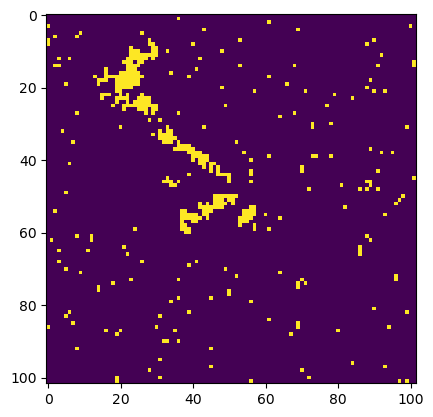

In [ ]:
plt.imshow(mbsp<-0.04)
plt.imshow((mbsp<-0.04) & ~(b9<170))


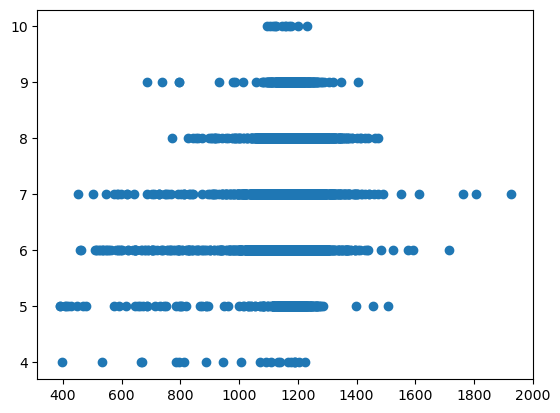

In [56]:
plt.scatter(b12.flatten(), b10.flatten())

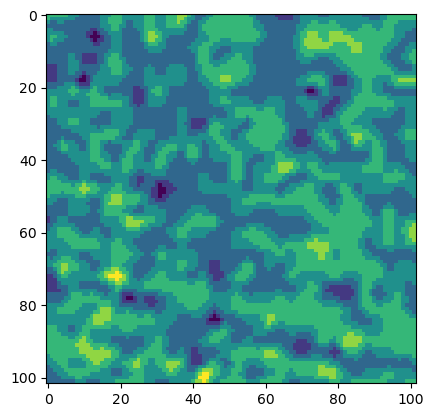

In [57]:
plt.imshow(b10)